In [1]:
import torch
from torch.utils.data import random_split, DataLoader
from torch import optim, nn
from torchvision import transforms as T
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from gtsrb import GTSRB

%matplotlib inline

In [2]:
metafile = 'C:\\imgcache\\traffic-images\\classids.csv'
train_dir = 'C:\\imgcache\\traffic-images\\Final_Training\\Images'
test_dir = 'C:\\imgcache\\traffic-images\\Final_Test\\Images'     # no labels, useless

# img transforms
transforms = T.Compose([
    T.Resize((32, 32)),
    T.ColorJitter(
        brightness=(0.8, 1.2),
        contrast=(0.8, 1.2),
        saturation=(0.8, 1.2),
        hue=0.25
    ),
    T.RandomAffine(
        degrees=45,
        translate=(0.05, 0.05)
    ),
    T.ToTensor()
])

testtransforms = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor()
])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: %s' % device)

using device: cuda


In [3]:
rawdata = GTSRB(train_dir, train=True, meta=metafile, transforms=transforms, testtransforms=testtransforms)
trainset, valset = random_split(rawdata, [len(rawdata)-9000, 9000])
print('trainning size: %d, val size: %d' % (len(trainset), len(valset)))

train_dl = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=rawdata.collate_fn)
val_dl = DataLoader(valset, batch_size=32, shuffle=False, collate_fn=rawdata.test_collate_fn)

trainning size: 30209, val size: 9000


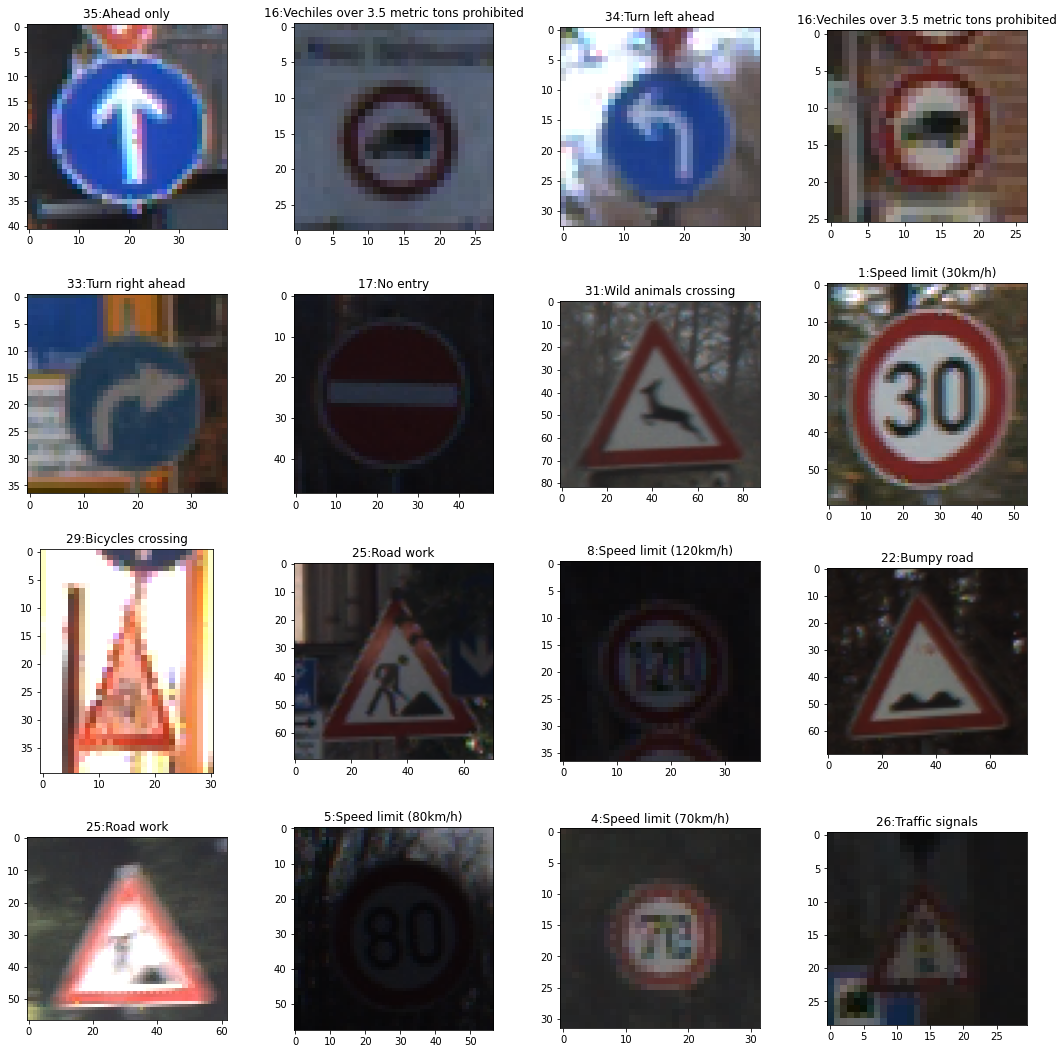

In [4]:
_, axis = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axis.flat):
    img, label = valset[i]
    ax.imshow(img)
    ax.set_title('%d:%s' % (label, rawdata.id2name['%05d' % label]))

plt.tight_layout()
plt.show()

In [5]:
class SignClassifier(nn.Module):
    @staticmethod
    def convBlock(in_chans, out_chans):
        return nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            SignClassifier.convBlock(3, 64),
            SignClassifier.convBlock(64, 64),
            SignClassifier.convBlock(64, 128),
            SignClassifier.convBlock(128, 64)
        )

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 43)
        )

    def forward(self, xs):
        fmaps = self.model(xs)
        fmaps = self.pooling(fmaps)
        preds = self.classifier(fmaps)
        return preds

model = SignClassifier().to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=5, verbose=True)
print("SignClassifier %s" % summary(model, torch.zeros((1, 3, 32, 32)).to(device), verbose=0))


SignClassifier ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Sequential: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─MaxPool2d: 3-4               [-1, 64, 16, 16]          --
|    └─Sequential: 2-2                   [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-5                  [-1, 64, 16, 16]          36,928
|    |    └─BatchNorm2d: 3-6             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-7                    [-1, 64, 16, 16]          --
|    |    └─MaxPool2d: 3-8               [-1, 64, 8, 8]            --
|    └─Sequential: 2-3                  

In [6]:
def train_batch(xs, ys, model, lossfn, optimizer):
    model.train()
    optimizer.zero_grad()

    yps = model(xs)
    loss = lossfn(yps, ys)
    loss.backward()
    optimizer.step()

    corrects = (yps.argmax(dim=1) == ys).cpu().tolist()

    return loss.cpu().item(), corrects

@torch.no_grad()
def evaluate_batch(xs, ys, model, lossfn):
    model.eval()
    yps = model(xs)
    loss = lossfn(yps, ys).cpu().item()
    corrects = (yps.argmax(dim=1) == ys).cpu().tolist()
    return loss, corrects

In [7]:
# Trainning loops
from time import time
train_losses = []
train_acces = []
val_losses = []
val_acces = []

for epoch in range(30):
    start = time()
    epoch_train_losses = []
    epoch_train_corrects = []
    epoch_val_losses = []
    epoch_val_corrects = []

    for xs, ys in train_dl:
        loss, corrects = train_batch(xs.to(device), ys.to(device), model, lossfn, optimizer)
        epoch_train_losses.append(loss)
        epoch_train_corrects.extend(corrects)
    epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(epoch_train_loss)
    epoch_train_acc = np.mean(epoch_train_corrects)
    train_acces.append(epoch_train_acc)

    for xs, ys in val_dl:
        loss, corrects = evaluate_batch(xs.to(device), ys.to(device), model, lossfn)
        epoch_val_losses.append(loss)
        epoch_val_corrects.extend(corrects)
    epoch_val_loss = np.mean(epoch_val_losses)
    val_losses.append(epoch_val_loss)
    epoch_val_acc = np.mean(epoch_val_corrects)
    val_acces.append(epoch_val_acc)

    lr_scheduler.step(epoch_val_acc)

    print('epoch %d: consume %.2f, train loss %.4f, val loss %.4f, train acc %.2f%%, val acc %.2f%%' % (
        epoch, time()-start, epoch_train_loss, epoch_val_loss, epoch_train_acc*100, epoch_val_acc*100
    ))


epoch 0: consume 40.15, train loss 2.2888, val loss 1.0472, train acc 34.17%, val acc 65.08%
epoch 1: consume 39.43, train loss 1.0415, val loss 0.5507, train acc 66.61%, val acc 80.36%
epoch 2: consume 39.33, train loss 0.7007, val loss 0.3287, train acc 77.34%, val acc 88.64%
epoch 3: consume 39.84, train loss 0.5352, val loss 0.1722, train acc 82.44%, val acc 95.39%
epoch 4: consume 39.25, train loss 0.4354, val loss 0.1268, train acc 85.95%, val acc 96.42%
epoch 5: consume 40.23, train loss 0.3740, val loss 0.0995, train acc 87.85%, val acc 97.19%
Epoch     7: reducing learning rate of group 0 to 2.5000e-04.
epoch 6: consume 39.86, train loss 0.3184, val loss 0.0937, train acc 90.00%, val acc 96.82%
epoch 7: consume 40.99, train loss 0.2243, val loss 0.0425, train acc 93.02%, val acc 98.80%
epoch 8: consume 42.06, train loss 0.1955, val loss 0.0552, train acc 93.91%, val acc 98.22%
epoch 9: consume 44.51, train loss 0.1798, val loss 0.0394, train acc 94.52%, val acc 98.80%
epoch 10